In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [3]:
df = pd.read_csv("/content/sample_data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
df.shape

(210013, 31)

In [5]:
df.isnull().values.any()

True

## Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

<ipython-input-6-627f3be2da59>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

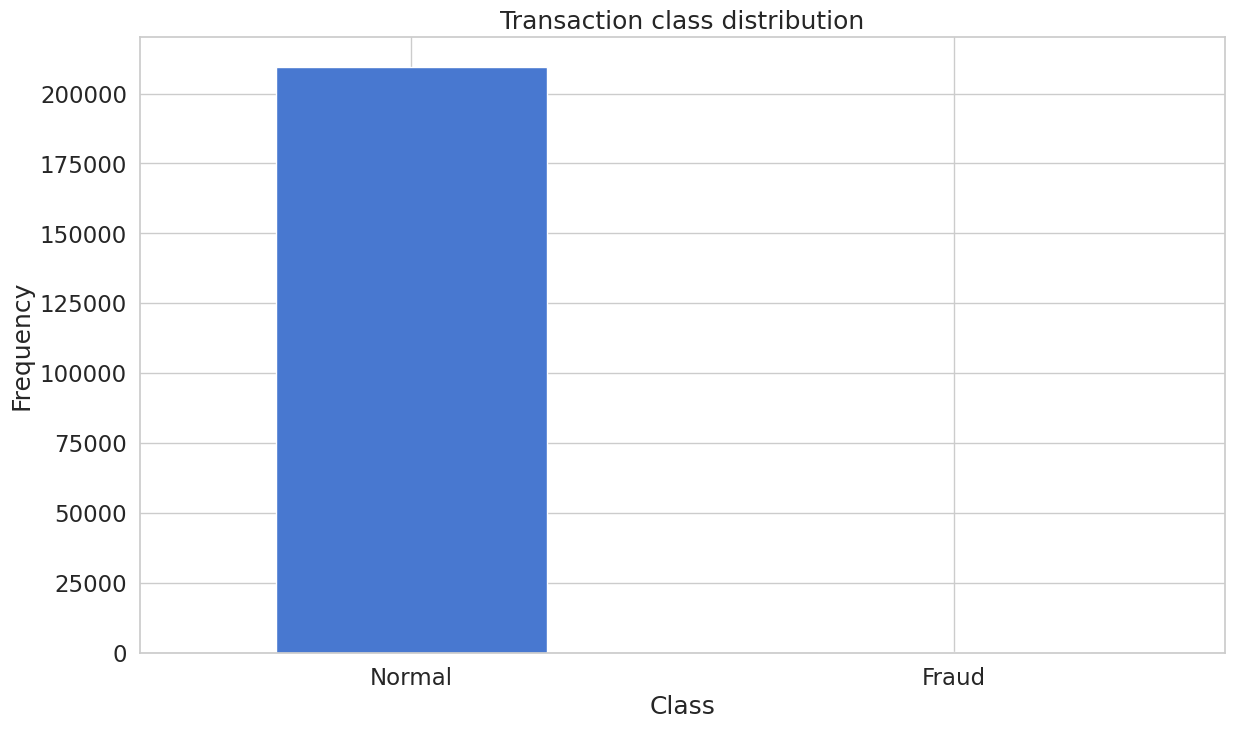

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(394, 31)

In [8]:
normal.shape

(209618, 31)

## Checking the amount of money involved in each kind of transaction

In [9]:
# Fraud transactions
frauds.Amount.describe()

,Amount
count,394.000000
mean,123.172970
std,256.841767
min,0.000000
25%,1.000000
50%,13.385000
75%,105.890000
max,2125.870000


In [11]:
# Non-fraud transactions
normal.Amount.describe()

,Amount
count,209618.000000
mean,89.889280
std,248.067423
min,0.000000
25%,6.000000
50%,23.020000
75%,79.540000
max,19656.530000


## Graphical representation of Amount

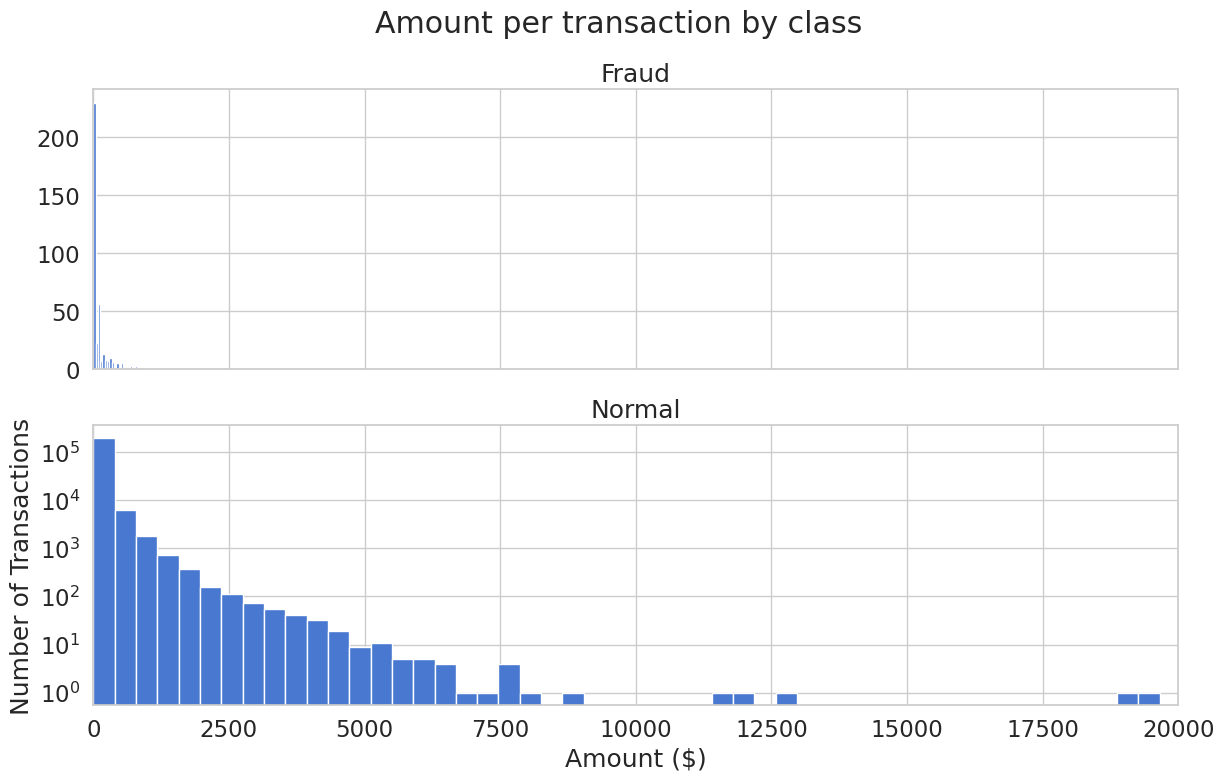

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

## Plotting time of transaction to check for correlations

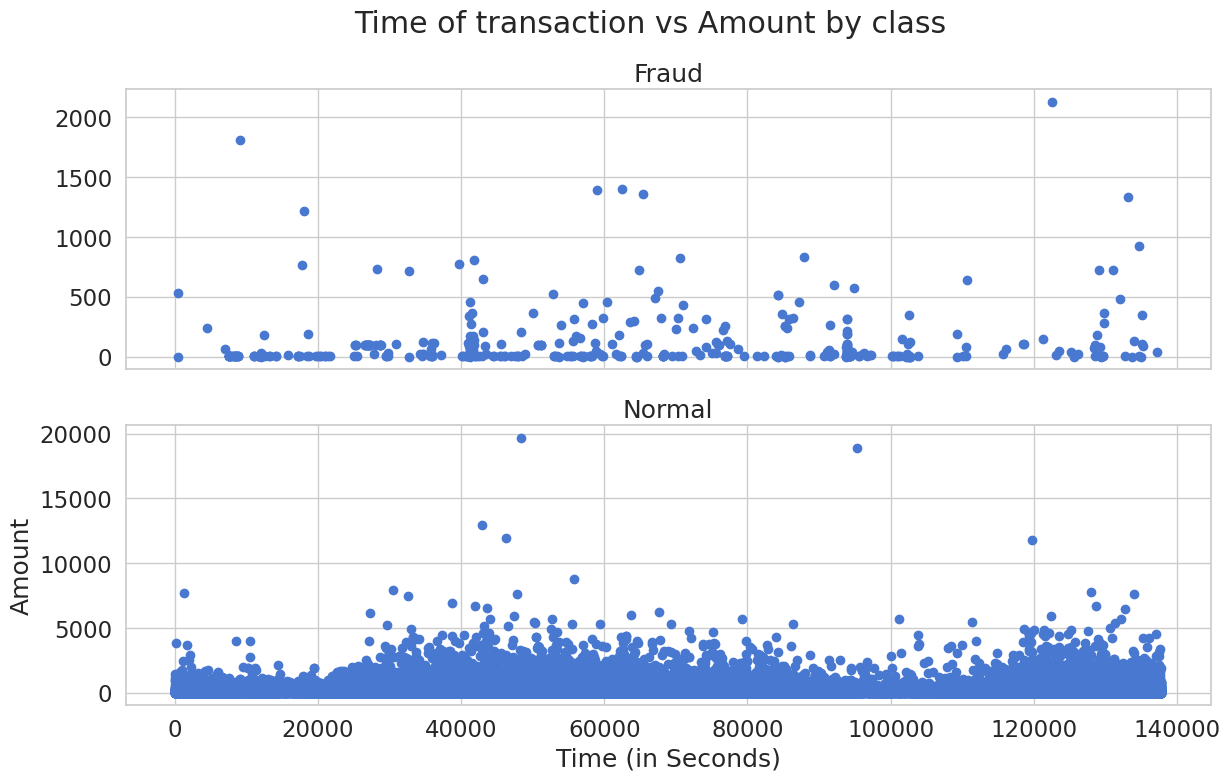

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [14]:
data = df.drop(['Time'], axis=1)

## Scaling the Amount using StandardScaler

In [15]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the model

In [17]:
import pandas as pd

non_fraud = data[data['Class'] == 0] #.sample(1000)
fraud = data[data['Class'] == 1]

# Use pd.concat instead of append
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

## Spiting the data into 80% training and 20% testing

In [18]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(167691, 29)

## Autoencoder model

In [19]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

## Training the credit card fraud detection model

In [20]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

## Scaling the values

In [21]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
                batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.0095 - val_loss: 0.8937
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0093 - val_loss: 0.8931
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0088 - val_loss: 0.8925
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0081 - val_loss: 0.8918
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0073 - val_loss: 0.8912
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0069 - val_loss: 0.8905
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0063 - val_loss: 0.8899
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0052 - val_loss: 0.8892
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0049 - val_loss: 0.8886
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0041 - val_loss: 0.8879


# Obtain the Hidden Representation

In [22]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [23]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [24]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

## Train, Test, Split

In [26]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

## Credit Card Fraud Detection Prediction model

In [27]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       741
         1.0       1.00      0.65      0.79       108

    accuracy                           0.96       849
   macro avg       0.98      0.82      0.88       849
weighted avg       0.96      0.96      0.95       849


Accuracy Score:  0.9552414605418139
